# LDA topic modelling

[guide](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) & [this](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
DATA_PATH = '../data/'

In [3]:
!ls {DATA_PATH}

realDonaldTrump.xlsx text.csv


In [4]:
text = pd.read_csv(DATA_PATH+'text.csv', header=None)
text.drop([0],1,inplace=True)
text.head()

,1
0,Gina Haspel is one step closer to leading our ...
1,...and voted against the massive Tax Cut Bill....
2,Lou Barletta will be a great Senator for Penns...
3,"Today, it was my great honor to welcome Presid..."
4,House votes today on Choice/MISSION Act. Who w...


In [5]:
# Convert to list
data = text[1].values.tolist()

# Remove new line
# data = [re.sub("\'", "", sent) for sent in data]

# Remove url
data = [re.sub("// ", "//", sent) for sent in data]
data = [re.sub("…", "", sent) for sent in data]
data = [re.sub("www. ", "www.", sent) for sent in data]
data = [re.sub(r"pic.\S+", "", sent) for sent in data]
data = [re.sub(r"http\S+", "", sent) for sent in data]

# Remove mentions @
# data = [re.sub(r"@\S+", "", sent) for sent in data]

pprint(data[1000])

('The Chinese Envoy, who just returned from North Korea, seems to have had no '
 'impact on Little Rocket Man. Hard to believe his people, and the military, '
 'put up with living in such horrible conditions. Russia and China condemned '
 'the launch.')


In [6]:
# Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[1000])

['the', 'chinese', 'envoy', 'who', 'just', 'returned', 'from', 'north', 'korea', 'seems', 'to', 'have', 'had', 'no', 'impact', 'on', 'little', 'rocket', 'man', 'hard', 'to', 'believe', 'his', 'people', 'and', 'the', 'military', 'put', 'up', 'with', 'living', 'in', 'such', 'horrible', 'conditions', 'russia', 'and', 'china', 'condemned', 'the', 'launch']


In [7]:
# Build the bigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[1000])

chinese envoy who just return north korea seem have have impact little rocket man hard believe  people military put live such horrible condition russia china condemn launch


In [13]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [14]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.1250420592193808 %


In [15]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [16]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -179784.90553048067
Perplexity:  572.5676428938303
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [26]:
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(n_jobs=6)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=6,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [5, 10, 15, 20, 25], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -63643.61911490374
Model Perplexity:  493.73793823837644


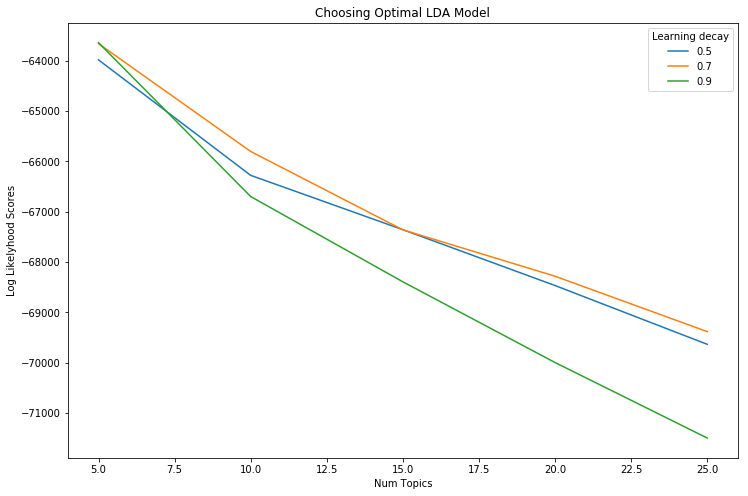

In [28]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20, 25]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [29]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=5, n_jobs=6,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [31]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Tweet" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Tweet0,0.09,0.13,0.02,0.74,0.02,3
Tweet1,0.19,0.77,0.01,0.01,0.01,1
Tweet2,0.01,0.95,0.01,0.01,0.01,1
Tweet3,0.03,0.03,0.89,0.03,0.03,2
Tweet4,0.1,0.58,0.29,0.01,0.01,1
Tweet5,0.04,0.04,0.04,0.84,0.04,3
Tweet6,0.02,0.02,0.6,0.02,0.34,2
Tweet7,0.01,0.01,0.01,0.96,0.01,3
Tweet8,0.03,0.03,0.86,0.03,0.03,2
Tweet9,0.01,0.37,0.01,0.6,0.01,3


In [32]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,951
1,4,628
2,1,622
3,3,617
4,0,382


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
2      25.033835        1       1  174.696182  171.823929
4      20.940476        1       2  -46.039555   66.273727
3      20.837110        1       3   80.545158 -238.412720
1      19.154782        1       4  255.257263  -68.135361
0      14.033797        1       5 -157.248352 -151.663834, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
651   Default  226.000000         tax  226.000000  30.0000  30.0000
663   Default  258.000000       thank  258.000000  29.0000  29.0000
265   Default  731.000000       great  731.000000  28.0000  28.0000
144   Default  153.000000         cut  153.000000  27.0000  27.0000
217   Default  242.000000        fake  242.000000  26.0000  26.0000
442   Default  270.000000        news  270.000000  25.0000  25.0000
64    Default  145.000000      border  145.000000  24.0000  24.0000
558   Default  165.000000  republican  165.000000  23.0000  23.0000
708   Default  133.000000        vote  133.000000  22.0000  22.0000
584   Default  148.000000         say  148.000000  21.0000  21.0000
294   Default  138.000000       honor  138.000000  20.0000  20.0000
574   Default  127.000000      russia  127.000000  19.0000  19.0000
132   Default  264.000000     country  264.000000  18.0000  18.0000
403   Default  142.000000      medium  142.000000  17.0000  17.0000
504   Default  230.000000   president  230.000000  16.0000  16.0000
441   Default  141.000000         new  141.000000  15.0000  15.0000
711   Default   84.000000        wall   84.000000  14.0000  14.0000
357   Default   83.000000         law   83.000000  13.0000  13.0000
194   Default  134.000000    election  134.000000  12.0000  12.0000
672   Default  221.000000       today  221.000000  11.0000  11.0000
341   Default  262.000000         job  262.000000  10.0000  10.0000
740   Default  228.000000        year  228.000000   9.0000   9.0000
25    Default  227.000000     america  227.000000   8.0000   8.0000
352   Default  103.000000       korea  103.000000   7.0000   7.0000
280   Default   81.000000  healthcare   81.000000   6.0000   6.0000
453   Default   79.000000   obamacare   79.000000   5.0000   5.0000
590   Default  106.000000    security  106.000000   4.0000   4.0000
452   Default   82.000000       obama   82.000000   3.0000   3.0000
633   Default   90.000000       story   90.000000   2.0000   2.0000
447   Default   92.000000       north   92.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
646    Topic5   20.322737     supreme   22.011942   1.8839  -5.2756
693    Topic5   10.606944      unable   11.493252   1.8835  -5.9258
64     Topic5  123.252472      border  145.542446   1.7975  -3.4731
20     Topic5   48.677744       allow   56.243060   1.8192  -4.4021
122    Topic5   60.129519    congress   72.100251   1.7821  -4.1908
632    Topic5   49.426310        stop   59.665212   1.7754  -4.3869
69     Topic5   48.133058       build   60.672689   1.7322  -4.4134
590    Topic5   78.425186    security  106.970262   1.6533  -3.9252
45     Topic5   30.970809       badly   37.271608   1.7785  -4.8543
187    Topic5   29.680716        drug   37.423864   1.7319  -4.8968
548    Topic5   25.712573     release   31.558030   1.7589  -5.0404
197    Topic5   39.667230         end   56.523089   1.6096  -4.6068
578    Topic5   31.441424        safe   42.042155   1.6732  -4.8392
585    Topic5   20.951409      school   24.855049   1.7928  -5.2451
225    Topic5   45.803428         fbi   73.934471   1.4849  -4.4630
579    Topic5   31.052892      safety   44.498323   1.6039  -4.8516
262    Topic5   28.754865  government   42.470375   1.5737  -4.9285
518    Topic5   29.033903     protect   44.483291   1.5371  -4.9189
472    Topic5   37.549354         pay   71.818617   1.3152  -4.6617
510    Topic5  

## the top 15 keywords each topic

In [36]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,border,wall,law,security,congress,country,act,illegal,people,immigration,mexico,stop,allow,build,court
Topic 1,tax,great,cut,republican,america,vote,big,make,healthcare,obamacare,american,join,democrat,need,strong
Topic 2,great,thank,job,today,president,honor,state,korea,day,north,meeting,united,trump,work,look
Topic 3,country,great,year,good,new,people,just,time,work,high,news,hard,bad,trade,dollar
Topic 4,fake,news,say,medium,trump,russia,election,story,obama,make,just,big,president,win,collusion


## How to predict the topics for a new piece of text?

In [42]:
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

In [41]:
# Predict the topic
mytext = ["Some text about Mexico, Wall and Border"]
topic, prob_scores = predict_topic(text = mytext)
print(topic[:5])
print(prob_scores)

['border', 'wall', 'law', 'security', 'congress']
[[0.79994049 0.05005442 0.05000223 0.05000202 0.05000082]]


In [44]:
# Predict the topic
mytext = ["Some text about CNN, Russian Witch Hunt!"]
topic, prob_scores = predict_topic(text = mytext)
print(topic[:5])
print(prob_scores)

['fake', 'news', 'say', 'medium', 'trump']
[[0.04000841 0.04000049 0.04000097 0.20317705 0.67681307]]


In [49]:
realtweet = ["....If this is done, illegal immigration will be stopped in it’s tracks - and at very little, \
                by comparison, cost. This is the only real answer - and we must continue to BUILD THE WALL!"]
topic, prob_scores = predict_topic(text = realtweet)
print(topic[:5])
print(prob_scores)

['border', 'wall', 'law', 'security', 'congress']
[[0.80832164 0.02067822 0.0204853  0.13043527 0.02007958]]
